# **EP3**
*Nome (matrícula):* Pedro Semcovici (12745511)


## **Introdução**
Dando continuidade à atividade proposta na Quick Task 3, neste notebook implementaremos um modelo de tradução sequência para sequência (Seq2Seq) utilizando Redes Neurais Recorrentes (RNNs) para converter datas no formato legível por humanos (como "12 de outubro de 2024") para um formato legível por máquinas (como "12/10/2024").

### **Contexto**

Modelos Seq2Seq são amplamente utilizados em tarefas que envolvem a transformação de uma sequência de entrada em outra sequência de saída, como tradução automática de idiomas, sumarização de texto e, neste caso, a transformação de formatos de data. Esses modelos geralmente consistem em dois componentes principais:

1. **Encoder**: Lê e compreende a sequência de entrada (neste caso, a data no formato legível por humanos).
2. **Decoder**: Gera a sequência de saída correspondente (a data no formato legível por máquinas).

### **Objetivo**

 O objetivo desta tarefa é aplicar os conceitos discutidos nos artigos "Sequence to Sequence Learning with Neural Networks" e "Neural Machine Translation by Jointly Learning to Align and Translate", utilizando-os em um problema de tradução de formatos de datas. Este exercício servirá como um exemplo prático do poder dos modelos Seq2Seq e do uso de RNNs em tarefas de tradução.

 Você deve rodar o código e tentar entender o que está acontecendo nas primeiras três seções. À medida que você se familiariza com a implementação, sinta-se à vontade para continuar a exploração em algum caminho que você achar interessante. Isso pode incluir experimentar diferentes configurações de modelo, aplicar novos datasets ou investigar alternativas aos mecanismos de atenção. O objetivo é que você desenvolva uma compreensão mais profunda dos modelos Seq2Seq e das suas aplicações práticas.

Este notebook possui as seguintes seções:

1. **Carregando os dados:** Iremos carregar um dataset pronto e em seguida converteremos as datas no formato de string para um formato numérico para que o modelo possa entender.
2. **Construção do modelo sem atenção:** Implementaremos o modelo Seq2Seq com base em GRU, uma variante das RNNs.
3. **Adicionando atenção:** Implementaremos uma versão do Decoder com atenção.
4. **Exercícios de Exploração Sugeridos:** Sugestões de explorações para que você possa explorar um pouco mais a tarefa.



### **Referências**

Este EP foi baseado em dois notebooks, do primeiro retirou a ideia do dataset [1] e o código PyTorch foi adaptado do segundo [2]. Revisão no texto e alguns comentários nos códigos foram gerados com ChatGPT.

[1] “Coursera-Deep-Learning-Specialization/C5 - Sequence Models/Week 3/Machine Translation/Neural Machine Translation with Attention - v4.Ipynb at Master · Amanchadha/Coursera-Deep-Learning-Specialization”. GitHub, https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C5%20-%20Sequence%20Models/Week%203/Machine%20Translation/Neural%20machine%20translation%20with%20attention%20-%20v4.ipynb. 

[2] NLP From Scratch: Translation with a Sequence to Sequence Network and Attention — PyTorch Tutorials 2.4.0+cu121 documentation. Por Sean Robertson. https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html.



----
# 0. Setup

In [1]:
import random
import re
import time
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.switch_backend('agg')
%matplotlib inline

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device={device}')

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# setar random seeds (nao havia no codigo original)
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
torch.manual_seed(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)


device=cuda


In [2]:
DATA_DIR = "../data/"

----
## 1. **Carregando os dados** 

Iremos carregar um dataset pronto e em seguida converteremos as datas no formato de string para um formato numérico que o modelo possa entender.

Vamos treinar o modelo em um dataset de 10.000 datas legíveis por humanos e suas equivalentes, padronizadas, legíveis por máquinas. 

In [3]:
def readDataset():
  file = DATA_DIR + 'datahumana-datamaquina.txt'
  # file = '' # Arquivo a ser lido na formatação entrada<tab>saida
  lines = open(file, encoding='utf-8').read().strip().split('\n')
  pairs = [[s for s in l.split('\t')] for l in lines]
  print(f'Read {len(pairs)} samples from {file}')
  print()
  print("\n".join(map(str, random.sample(pairs, 15))))
  return pairs

pairs = readDataset()

Read 10000 samples from ../data/datahumana-datamaquina.txt

['sabado 23 de abril de 1977', '23/04/1977']
['quinta-feira 11 de marco de 2010', '11/03/2010']
['maio 24 1989', '24/05/1989']
['15 novembro 1988', '15/11/1988']
['18 ago. 2001', '18/08/2001']
['04/08/1987', '04/08/1987']
['sexta-feira 25 de setembro de 2020', '25/09/2020']
['7 de fevereiro de 2024', '07/02/2024']
['janeiro 13 1986', '13/01/1986']
['domingo 29 de fevereiro de 2004', '29/02/2004']
['22 07 89', '22/07/1989']
['fevereiro 25 2015', '25/02/2015']
['sabado 14 de setembro de 2013', '14/09/2013']
['sabado 3 de novembro de 2007', '03/11/2007']
['quarta-feira 6 de junho de 1990', '06/06/1990']


É necessário codificar as entradas e saídas em representações que o modelo consiga entender. Neste caso, representaremos as 'palavras' como inteiros atribuídos de forma sequencial.


Além disso, é necessário definir os tokens especiais para o início e fim de uma sequência.
- SOS_token (Start of Sequence - Início da Sequência) é usado para inicializar a entrada do decodificador ao gerar frases.
- EOS_token (End of Sequence - Fim da Sequência) indica o fim da frase, para que o decodificador saiba quando parar de gerar.


In [4]:
SOS_token = 0
EOS_token = 1

def prepareData(pairs):
  input_dict  = {"SOS": SOS_token, "EOS": EOS_token}
  output_dict = {"SOS": SOS_token, "EOS": EOS_token}

  input_dict_reverse  = {SOS_token: "SOS", EOS_token: "EOS"}
  output_dict_reverse = {SOS_token: "SOS", EOS_token: "EOS"}

  for pair in pairs:
    ipt, tgt = pair
    
    mask = '([^a-zA-Z0-9])'
    result = [token for token in re.split(mask, ipt) if token.strip()]
    for word_input in result:
      if word_input not in input_dict:
        next_int = max(input_dict.values()) + 1
        input_dict[word_input] = next_int
        input_dict_reverse[next_int] = word_input

    for word_output in re.split(mask, tgt):
      if word_output not in output_dict:
        next_int = max(output_dict.values()) + 1
        output_dict[word_output] = next_int
        output_dict_reverse[next_int] = word_output

  print(f'Number of input words: {len(input_dict.keys())}')
  print(f'Number of output words: {len(output_dict.keys())}')

  return input_dict, output_dict, input_dict_reverse, output_dict_reverse

input_dict, output_dict, input_dict_reverse, output_dict_reverse = prepareData(pairs)

Number of input words: 164
Number of output words: 89


In [5]:
print(input_dict)

print(input_dict_reverse)

{'SOS': 0, 'EOS': 1, '8': 2, 'julho': 3, '2001': 4, 'domingo': 5, '15': 6, 'de': 7, 'setembro': 8, '2013': 9, 'quarta': 10, '-': 11, 'feira': 12, '12': 13, 'dezembro': 14, '1973': 15, '10': 16, '/': 17, '06': 18, '1972': 19, 'sexta': 20, '26': 21, 'abril': 22, '1974': 23, 'terca': 24, '5': 25, '1983': 26, '29': 27, 'mar': 28, '.': 29, '1987': 30, '2': 31, '94': 32, 'segunda': 33, '11': 34, '1978': 35, 'quinta': 36, '14': 37, 'janeiro': 38, '1999': 39, 'agosto': 40, '2015': 41, '1996': 42, '22': 43, '2005': 44, '01': 45, 'out': 46, '2011': 47, 'sabado': 48, '6': 49, 'junho': 50, '1981': 51, 'marco': 52, 'maio': 53, '3': 54, '2010': 55, '1986': 56, '31': 57, '2018': 58, '1971': 59, 'jan': 60, '1989': 61, '23': 62, '7': 63, '2006': 64, '19': 65, 'outubro': 66, '1990': 67, '1998': 68, '30': 69, '2022': 70, '07': 71, '92': 72, '24': 73, 'nov': 74, '13': 75, '16': 76, 'mai': 77, '1980': 78, 'ago': 79, '1979': 80, '2020': 81, '28': 82, '03': 83, '05': 84, '04': 85, '81': 86, '75': 87, '1977':

In [6]:
def indexesFromSentence(language_dict, sentence, verbose=False):
  '''
    Função utilitária para converter uma sentença em índices
  '''
  encoded = [language_dict[word] for word in re.split('([^a-zA-Z0-9])', sentence) if word.strip()]
  if verbose:
    print(f"'{sentence}' => {encoded}")
  return encoded

indexesFromSentence(input_dict, 'segunda-feira 18 de outubro de 1999', verbose=True);
indexesFromSentence(output_dict, '30/09/2022', verbose=True);


'segunda-feira 18 de outubro de 1999' => [33, 11, 12, 102, 7, 66, 7, 39]
'30/09/2022' => [46, 3, 7, 3, 47]


In [7]:
# Funções utilitárias
def tensorFromSentence(language_dict, sentence):
  indexes = indexesFromSentence(language_dict, sentence)
  indexes.append(EOS_token)
  return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_dict, pair[0])
    target_tensor = tensorFromSentence(output_dict, pair[1])
    return (input_tensor, target_tensor)

tensorsFromPair(['segunda-feira 18 de outubro de 1999', '18/10/1999'])

(tensor([[ 33,  11,  12, 102,   7,  66,   7,  39,   1]], device='cuda:0'),
 tensor([[65,  3, 11,  3, 28,  1]], device='cuda:0'))

### Implementando data loader para treinamento

In [8]:
def get_dataloader(batch_size, pairs, input_dict, output_dict):
  n = len(pairs)
  input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
  target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

  for idx, (inp, tgt) in enumerate(pairs):
    inp_ids = indexesFromSentence(input_dict, inp)
    tgt_ids = indexesFromSentence(output_dict, tgt)
    inp_ids.append(EOS_token)
    tgt_ids.append(EOS_token)
    input_ids[idx, :len(inp_ids)] = inp_ids
    target_ids[idx, :len(tgt_ids)] = tgt_ids

  train_data = TensorDataset(torch.LongTensor(input_ids).to(device), torch.LongTensor(target_ids).to(device))

  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
  return train_dataloader

----
## 2. **Construção do modelo sem atenção:**

Dando continuidade, vamos implementar o modelo Seq2Seq utilizando a célula GRU.

Uma rede Encoder-Decoder é composta por duas RNNs: o Encoder e o Decoder.
O Encoder lê uma sequência de entrada e gera um vetor único, que o Decoder usa para produzir a sequência de saída.

Por simplicidade, utilizaremos a célula GRU. Como sugestão, você também pode explorar outras células RNN, como, por exemplo, a LSTM.

In [9]:
class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size, dropout_p=0.1):
    """
    Initializes the encoding layer (Encoder) of an RNN.
        
    Parameters:
    - input_size: The number of expected features in the input x
    - hidden_size: The number of features in the hidden state h
    - dropout_p: If non-zero, introduces a Dropout layer on the outputs of each GRU layer except the last layer
    """      
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size

    # Embedding layer that transforms word indices into dense vectors of size 'hidden_size'.
    self.embedding = nn.Embedding(input_size, hidden_size)

    # Defines the GRU (Gated Recurrent Unit) with both input and output dimensions of 'hidden_size'.
    # 'batch_first=True' indicates that the first input dimension is the batch (batch_size, seq_len, hidden_size).
    self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    # Dropout applied after the embedding layer to prevent overfitting.
    self.dropout = nn.Dropout(dropout_p)

  def forward(self, input):
    """
    Defines the forward pass of the model.
    
    Parameter:
    - input: Sequence of word indices of size (batch_size, seq_len).
    
    Returns:
    - output: GRU outputs for each step in the sequence (batch_size, seq_len, hidden_size).
    - hidden: The last hidden state vector of the GRU (1, batch_size, hidden_size).
        """    
    embedded = self.dropout(self.embedding(input))
    output, hidden = self.gru(embedded)
    return output, hidden     

In [10]:
# MAX_LENGTH defines the sequence length limit
MAX_LENGTH = 18

In [11]:
class DecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size):
    """
    Initializes the decoding layer (Decoder) of an RNN.
    
    Parameters:
    - hidden_size: The size of the hidden state vector.
    - output_size: The size of the output vocabulary (number of unique words in the target language).
    """    
    super(DecoderRNN, self).__init__()

    # Embedding layer that transforms word indices into dense vectors of size 'hidden_size'.
    self.embedding = nn.Embedding(output_size, hidden_size)

    # Defines a GRU layer that processes input sequences. Both input and output dimensions are 'hidden_size'.
    self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    # Linear layer that maps the hidden state of the GRU to the output vocabulary space.
    self.out = nn.Linear(hidden_size, output_size)

  def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
    """
    Defines the forward pass for the decoder.
    
    Parameters:
    - encoder_outputs: The output sequence from the encoder (batch_size, seq_len, hidden_size).
    - encoder_hidden: The last hidden state of the encoder (1, batch_size, hidden_size).
    - target_tensor: The target sequence for teacher forcing (optional).
    
    Returns:
    - decoder_outputs: The output probabilities (log-softmax) for each time step (batch_size, seq_len, output_size).
    - decoder_hidden: The final hidden state of the decoder (1, batch_size, hidden_size).
    - None: Placeholder for consistency with other methods (e.g., attention).
    """    
    batch_size = encoder_outputs.size(0)

    # Initial decoder input is the <SOS> token for every sequence in the batch.
    decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
    decoder_hidden = encoder_hidden
    decoder_outputs = []

    # Loop through each time step
    for i in range(MAX_LENGTH):
      # Call the forward_step function to get output and hidden state for the current time step.
      decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
      decoder_outputs.append(decoder_output)

      if target_tensor is not None:
        # Teacher forcing: Use the target token as the next input to the decoder.
        decoder_input = target_tensor[:, i].unsqueeze(1) 
      else:
        # Without teacher forcing: use its own predictions as the next input
        _, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze(-1).detach()  

    # Concatenate all the decoder outputs along the time step dimension.
    decoder_outputs = torch.cat(decoder_outputs, dim=1)

    # Apply log softmax to the outputs to get log-probabilities.
    decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)

    # Return the outputs, final hidden state, and `None` (for consistency with attention models implemented next).
    return decoder_outputs, decoder_hidden, None 

  def forward_step(self, input, hidden):
    """
    Processes a single step in the decoding sequence.
    
    Parameters:
    - input: The current input to the decoder (batch_size, 1).
    - hidden: The current hidden state of the decoder (1, batch_size, hidden_size).
    
    Returns:
    - output: The predicted output (batch_size, 1, output_size).
    - hidden: The updated hidden state (1, batch_size, hidden_size).
    """    
    output = self.embedding(input)
    output = F.relu(output)
    output, hidden = self.gru(output, hidden)
    output = self.out(output)
    return output, hidden

### **Treinando uma época**

Para treinar, inserimos a sequência de entrada no Encoder, e capturamos  cada saída e o último hidden state. 
A partir disso, o Decoder é alimentado com o token de início de sequência (SOS) e o último hidden state do Encoder.

Para acelerar a convergência do treinamento, utilizamos o Teacher Forcing, ou seja, realimentamos o Decoder com as palavras esperadas, em vez de usar a última saída gerada pelo modelo.

In [12]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
  """
  Train the encoder and decoder for one epoch.
  
  Parameters:
  - dataloader: Iterable that provides batches of input and target tensors.
  - encoder: The encoder model.
  - decoder: The decoder model.
  - encoder_optimizer: Optimizer for updating the encoder's parameters.
  - decoder_optimizer: Optimizer for updating the decoder's parameters.
  - criterion: Loss function to measure the difference between the predicted and target outputs.

  Returns:
  - The average loss over the epoch.
  """
  total_loss = 0
  for data in dataloader:
    input_tensor, target_tensor = data

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_outputs, encoder_hidden = encoder(input_tensor)
    decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

    loss = criterion(
        decoder_outputs.view(-1, decoder_outputs.size(-1)),
        target_tensor.view(-1)
    )
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [13]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001):
  loss_points = []
  
  plot_losses = []
  print_loss_total = 0  # Reset every print_every
  plot_loss_total = 0  # Reset every plot_every

  encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
  criterion = nn.NLLLoss()

  for epoch in range(1, n_epochs + 1):
    loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    loss_points.append(loss)

    if epoch % 10 == 0:
      print(f'Epoch: {epoch:4}/{n_epochs:4} - Loss: {loss:.4f}')

  
  return loss_points


In [14]:
hidden_size = 128
batch_size = 1024

train_dataloader = get_dataloader(batch_size, pairs, input_dict, output_dict)

encoder = EncoderRNN(
  input_size = len(input_dict.keys()),
  hidden_size = hidden_size
).to(device)

decoder = DecoderRNN(
  hidden_size = hidden_size,
  output_size = len(output_dict.keys())
).to(device)


loss_points = train(train_dataloader, encoder, decoder, 100, learning_rate=0.001)


Epoch:   10/ 100 - Loss: 0.6113
Epoch:   20/ 100 - Loss: 0.5084
Epoch:   30/ 100 - Loss: 0.3663
Epoch:   40/ 100 - Loss: 0.2381
Epoch:   50/ 100 - Loss: 0.1396
Epoch:   60/ 100 - Loss: 0.0537
Epoch:   70/ 100 - Loss: 0.0232
Epoch:   80/ 100 - Loss: 0.0132
Epoch:   90/ 100 - Loss: 0.0088
Epoch:  100/ 100 - Loss: 0.0063


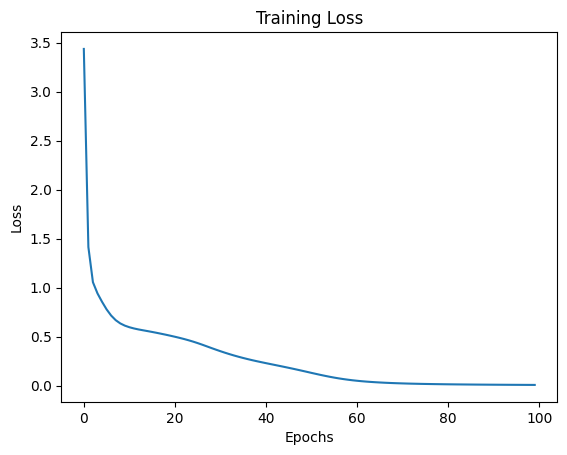

In [15]:
def plot_train_loss(loss_points):
  plt.plot(loss_points);
  plt.title('Training Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
plot_train_loss(loss_points);

### **Avaliando a predição**

Para avaliar a predição, usamos o modelo de forma semelhante ao treinamento, mas sem utilizar o Teacher Forcing. Simplesmente realimentamos o decoder com suas próprias predições a cada passo. Quando o decoder produz o token EOS, o processo é interrompido.

In [16]:
def evaluate(encoder, decoder, sentence):
  encoder.eval()
  decoder.eval()
  with torch.no_grad():
    input_tensor = tensorFromSentence(input_dict, sentence)

    encoder_outputs, encoder_hidden = encoder(input_tensor)
    decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

    _, topi = decoder_outputs.topk(1)
    decoded_ids = topi.squeeze()

    decoded_words = []
    for idx in decoded_ids:
      if idx.item() == EOS_token:
        # decoded_words.append('<EOS>')
        break
      decoded_words.append(output_dict_reverse[idx.item()])
  return decoded_words, decoder_attn

In [17]:
def evaluateRandomly(encoder, decoder, n=5):
  for i in range(n):
    pair = random.choice(pairs)
    print(f'Input: {pair[0]}')
    print(f'Ground truth: {pair[1]}')
    output_words, _ = evaluate(encoder, decoder, pair[0])
    output_sentence = ''.join(output_words)
    print(f'Predicted: {output_sentence}')
    print('')

In [18]:
evaluateRandomly(encoder, decoder)

Input: quarta-feira 16 de junho de 1982
Ground truth: 16/06/1982
Predicted: 16/06/1982

Input: outubro 10 2004
Ground truth: 10/10/2004
Predicted: 10/10

Input: sexta-feira 24 de outubro de 2014
Ground truth: 24/10/2014
Predicted: 24/10

Input: 10 de dezembro de 1993
Ground truth: 10/12/1993
Predicted: 10/12/1993

Input: sabado 4 de outubro de 2008
Ground truth: 04/10/2008
Predicted: 04/10/2008



----
# **3. Adicionando Atenção**

A atenção permite que a rede do decoder "foque" em uma parte diferente das saídas do encoder a cada passo das suas próprias saídas. Primeiro, calculamos um conjunto de pesos de atenção. Esses pesos serão multiplicados pelos vetores de saída do encoder para criar uma combinação ponderada. O resultado (chamado attn_applied no código) deve conter informações sobre aquela parte específica da sequência de entrada e, assim, ajudar o decoder a escolher as palavras corretas na saída.

![](https://i.imgur.com/1152PYf.png)

In [19]:
# Bahdanau attention, also known as additive attention, is a commonly used
# attention mechanism in sequence-to-sequence models, particularly in
# neural machine translation tasks. It was introduced by Bahdanau et al.
# in their paper titled [Neural Machine Translation by Jointly Learning to
# Align and Translate](https://arxiv.org/pdf/1409.0473.pdf). This
# attention mechanism employs a learned alignment model to compute
# attention scores between the encoder and decoder hidden states. It
# utilizes a feed-forward neural network to calculate alignment scores.

class BahdanauAttention(nn.Module):
  def __init__(self, hidden_size):
    '''Initialize the BahdanauAttention class.
        
    Parameters:
    - hidden_size: The size of the hidden state used in the attention mechanism.
    '''
    super(BahdanauAttention, self).__init__()
    self.Wa = nn.Linear(hidden_size, hidden_size)
    self.Ua = nn.Linear(hidden_size, hidden_size)
    self.Va = nn.Linear(hidden_size, 1)

  def forward(self, query, keys):
    scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
    scores = scores.squeeze(2).unsqueeze(1)

    weights = F.softmax(scores, dim=-1)
    context = torch.bmm(weights, keys)
    return context, weights  # Return the context vector and attention weights.

In [20]:
class AttnDecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size, dropout_p=0.1):
    """
    Initializes the decoding layer (Decoder with Attention) of an RNN.
    
    Parameters:
    - hidden_size: The size of the hidden state vector.
    - output_size: The size of the output vocabulary (number of unique words in the target language).
    - dropout_p: The dropout probability for regularization during training.
    """    
    super(AttnDecoderRNN, self).__init__()
    
    # Embedding layer transforms word indices into dense vectors of size 'hidden_size'.
    self.embedding = nn.Embedding(output_size, hidden_size)
    
    # Attention mechanism to compute context vectors from encoder outputs.
    self.attention = BahdanauAttention(hidden_size)

    # GRU layer that processes the combined input of embeddings and context vectors.
    self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)

    # Linear layer maps the GRU output to the output vocabulary space.
    self.out = nn.Linear(hidden_size, output_size)

    # Dropout layer for regularization to prevent overfitting during training.
    self.dropout = nn.Dropout(dropout_p)

  def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
    """
    Defines the forward pass for the attention decoder.
    
    Parameters:
    - encoder_outputs: The output sequences from the encoder (shape: batch_size, seq_len, hidden_size).
    - encoder_hidden: The last hidden state of the encoder (shape: 1, batch_size, hidden_size).
    - target_tensor: The target sequence for teacher forcing (optional).
    
    Returns:
    - decoder_outputs: The output probabilities (log-softmax) for each time step (shape: batch_size, seq_len, output_size).
    - decoder_hidden: The final hidden state of the decoder (shape: 1, batch_size, hidden_size).
    - attentions: The attention weights for each time step (shape: batch_size, seq_len).
    """        
    batch_size = encoder_outputs.size(0)
    decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
    decoder_hidden = encoder_hidden
    decoder_outputs = []
    attentions = []

    # Loop through each time step to generate the output sequence.
    for i in range(MAX_LENGTH):
      # Call the forward_step function to get output, hidden state, and attention weights for the current time step.
      decoder_output, decoder_hidden, attn_weights = self.forward_step(decoder_input, decoder_hidden, encoder_outputs)
      decoder_outputs.append(decoder_output)
      attentions.append(attn_weights)

      if target_tensor is not None:
        # Teacher forcing: Feed the target token as the next input to the decoder.
        decoder_input = target_tensor[:, i].unsqueeze(1)
      else:
        # Without teacher forcing: Use its own predictions as the next input.
        _, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze(-1).detach()  # detach from history as input

    # Concatenate all decoder outputs along the time step dimension.
    decoder_outputs = torch.cat(decoder_outputs, dim=1)

    # Apply log softmax to the outputs to get log-probabilities.
    decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)

    # Concatenate all attention weights along the time step dimension.
    attentions = torch.cat(attentions, dim=1)

    # Return the outputs, final hidden state, and attention weights.
    return decoder_outputs, decoder_hidden, attentions


  def forward_step(self, input, hidden, encoder_outputs):
    """
    Processes a single step in the decoding sequence with attention.
    
    Parameters:
    - input: The current input to the decoder (shape: batch_size, 1).
    - hidden: The current hidden state of the decoder (shape: 1, batch_size, hidden_size).
    - encoder_outputs: The outputs from the encoder (shape: batch_size, seq_len, hidden_size).
    
    Returns:
    - output: The predicted output (shape: batch_size, 1, output_size).
    - hidden: The updated hidden state (shape: 1, batch_size, hidden_size).
    - attn_weights: The attention weights for the current input (shape: batch_size, seq_len).
    """       
    # Get the embedded representation of the current input with dropout for regularization. 
    embedded =  self.dropout(self.embedding(input))

    # Permute hidden state to match the query shape for the attention mechanism.
    query = hidden.permute(1, 0, 2)

    # Compute the context vector and attention weights using the attention mechanism.
    context, attn_weights = self.attention(query, encoder_outputs)

    # Concatenate the embedded input and the context vector for the GRU.
    input_gru = torch.cat((embedded, context), dim=2)

    # Pass the combined input through the GRU layer to get the output and updated hidden state.
    output, hidden = self.gru(input_gru, hidden)

    # Map the GRU output to the output vocabulary space using the linear layer.
    output = self.out(output)

    return output, hidden, attn_weights

### Treinando

In [21]:
hidden_size = 128
batch_size = 1024

train_dataloader = get_dataloader(batch_size, pairs, input_dict, output_dict)

encoder = EncoderRNN(
  input_size = len(input_dict.keys()),
  hidden_size = hidden_size
).to(device)

# decoder = DecoderRNN(
decoder = AttnDecoderRNN(
  hidden_size = hidden_size,
  output_size = len(output_dict.keys())
).to(device)


loss_points_attention = train(train_dataloader, encoder, decoder, 100, learning_rate=0.001)


Epoch:   10/ 100 - Loss: 0.5924
Epoch:   20/ 100 - Loss: 0.5544
Epoch:   30/ 100 - Loss: 0.4953
Epoch:   40/ 100 - Loss: 0.4024
Epoch:   50/ 100 - Loss: 0.2537
Epoch:   60/ 100 - Loss: 0.1685
Epoch:   70/ 100 - Loss: 0.0728
Epoch:   80/ 100 - Loss: 0.0226
Epoch:   90/ 100 - Loss: 0.0110
Epoch:  100/ 100 - Loss: 0.0069


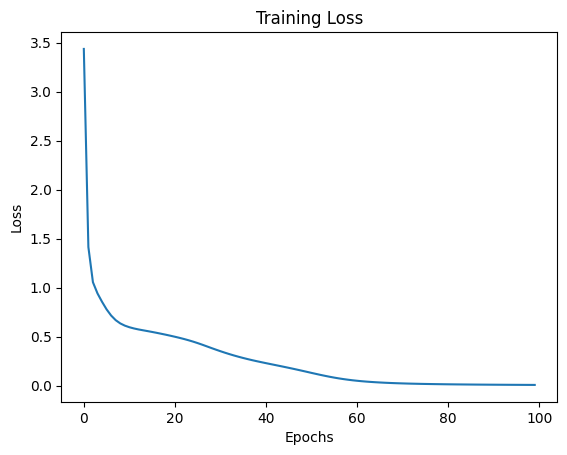

In [22]:
plot_train_loss(loss_points)

In [23]:
evaluateRandomly(encoder, decoder)

Input: marco 13 2019
Ground truth: 13/03/2019
Predicted: 13/03/1996

Input: sabado 5 de maio de 1973
Ground truth: 05/05/1973
Predicted: 05/05/1973

Input: 30 de nov. de 1999
Ground truth: 30/11/1999
Predicted: 30/11

Input: 22 janeiro 1990
Ground truth: 22/01/1990
Predicted: 22/01/2002

Input: domingo 27 de fevereiro de 2000
Ground truth: 27/02/2000
Predicted: 27/02/2000



### **Visualizando as máscaras de Atenção**

Uma propriedade útil do mecanismo de atenção é a alta interpretabilidade de suas saídas. Como ele é usado para atribuir pesos específicos às saídas do encoder da sequência de entrada, podemos imaginar onde a rede está mais focada em cada passo de tempo.

input = 20 de novembro de 2015
output = 20/11/2015


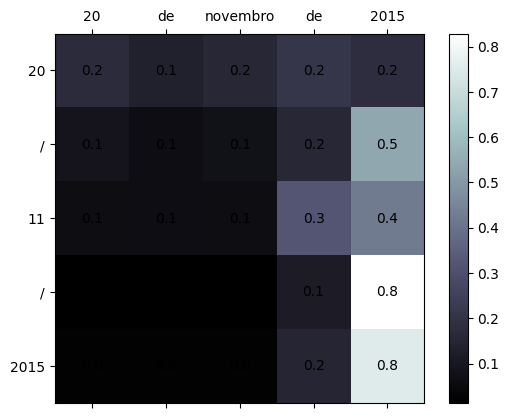

input = 22 de maio 1981
output = 22/05/1981


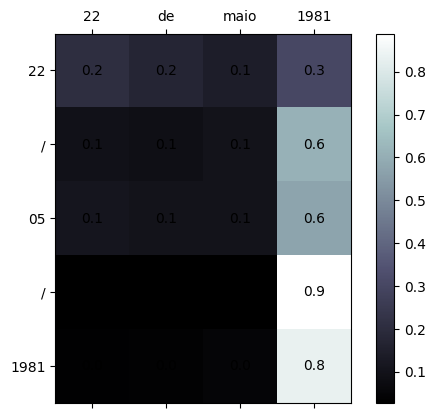

input = 15.11.2013
output = 15/11


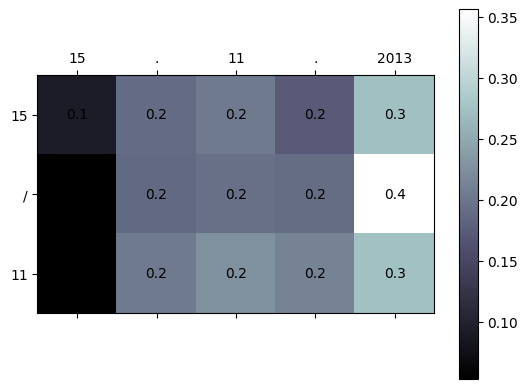

input = 01 de jan. 1989
output = 01/1989


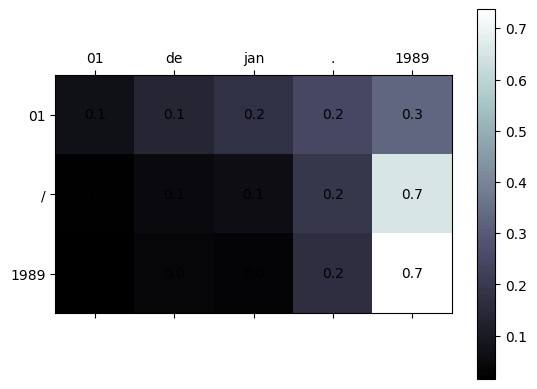

In [24]:
%matplotlib inline
def showAttention(input_sentence, output_words, attentions):
  fig = plt.figure()
  ax = fig.add_subplot()
  data = attentions.cpu().numpy().squeeze()
  cax = ax.matshow(data, cmap='bone')
  fig.colorbar(cax)

  # Set up axes
  input_tokens = [token for token in re.split('([^a-zA-Z0-9])', input_sentence) if token.strip()]
  ax.set_xticks(ticks=range(len(input_tokens)), labels=input_tokens)
  ax.set_yticks(ticks=range(len(output_words)), labels=output_words)

  # Show label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

  plt.show()


def evaluateAndShowAttention(input_sentence):
  output_words, attentions = evaluate(encoder, decoder, input_sentence)
  print('input =', input_sentence)
  print('output =', ''.join(output_words))
  showAttention(input_sentence, output_words, attentions[0, :len(output_words), 1:])
  plt.show()



evaluateAndShowAttention('20 de novembro de 2015')

evaluateAndShowAttention('22 de maio 1981')

evaluateAndShowAttention('15.11.2013')

evaluateAndShowAttention('01 de jan. 1989')

----
#  **4. Exercícios de Exploração Sugeridos**

1. **Experimentar com outros datasets:**
   - Tente utilizar um dataset diferente para observar como o modelo se comporta com dados novos. Algumas sugestões incluem:
     - **Outro par de idiomas**: Experimente traduzir entre diferentes idiomas para testar a flexibilidade do modelo Seq2Seq.
     - **Chat → Resposta**: Utilize um dataset de conversas e explore o mapeamento de mensagens para respostas.
     - **Pergunta → Resposta**: Experimente um dataset de perguntas e respostas, onde o modelo aprende a fornecer respostas a perguntas específicas.

2. **Explorar codificações alternativas:**
   - Em vez de utilizar representações simples de palavras, tente usar **embeddings de palavras**. Isso pode melhorar a capacidade do modelo de capturar relacionamentos semânticos entre as palavras. Exemplos incluem: **Word2Vec** ou **GloVe**: Substitua as embeddings atuais por embeddings pré-treinadas para aproveitar o conhecimento adicional aprendido em grandes corpora.
   - Experimente outras maneiras de **tokenizar o dataset**. Por exemplo, você pode usar subpalavras (como BPE - Byte Pair Encoding) ou tokens baseados em caracteres em vez de palavras inteiras.

3. **Ajustes na arquitetura do modelo:**
   - **Aumentar a complexidade do modelo**: Tente aumentar o número de camadas, o número de unidades ocultas (*hidden units*) e experimente treinar com sentenças mais longas. Compare o tempo de treinamento e a qualidade dos resultados obtidos. Isso pode revelar como o modelo escala com a complexidade.
   - Em vez de utilizar células GRU, tente implementar o modelo com células **LSTM**. Compare os resultados e observe as diferenças no tempo de convergência e na qualidade da tradução.

   - **Treinamento de um autoencoder**:
     - Use um arquivo de tradução em que as frases de entrada e saída sejam idênticas (exemplo: "Eu sou um teste \t Eu sou um teste").
     - Treine o modelo como um **autoencoder**.
     - Após o treinamento, **salve apenas a rede Encoder** e, em seguida, treine um novo Decoder para realizar a tradução a partir das representações do Encoder.

4. **Explorar diferentes mecanismos de atenção:**
   - Tente usar outro tipo de **mecanismo de atenção** (como **multi-head attention**) e compare os resultados em termos de precisão e capacidade de generalização.

5. **Revisão e Contribuição:**
   - Como o notebook não foi extensivamente testado, sinta-se à vontade para procurar e corrigir quaisquer erros que encontrar. Agradecemos qualquer contribuição para melhorar o código e a documentação. Seu feedback é valioso para aprimorar a experiência de aprendizado para todos os alunos.

...


**Resumo das mudanção desenvolvidas**:  
A partir daqui, temos a implementação de algumas sugestões de exploração sugeridas em `4.`, sendo elas a substituição da representação simples de palavras por um Word2Vec CBOW, a troca da GRU por LSTM e, por fim, a troca da atenção pela Multihead Attention. Além disso, no código acima não havia uma separação própria de treino e teste, então foram realizados 2 experimentos, um imitando a avaliação realizada acima e outro realizando uma divisão de treino e teste no conjunto de dados.  

**Intruções para execução:**
- Versão do Python utilizada: 3.12.7
- OS utilizado: Pop.OS 22.04
- Para executar esse código é preciso instalar algumas bibliotecas adicionais do Python que podem ser instaladas fácilmente através do arquivo requirements.txt com `pip install -r ../requirements.txt`

**Principais dificuldades com o EP:**  
A maior dificuldade na realização do EP foi aprender a utilizar Pytorch. Os outros EPs realizei utilizando o Tensorflow através do Keras, já que são bibliotecas que eu tinha um conhecimento prévio à disciplina. Contudo, dado que esse EP já continha uma implementação em Pytorch que poderia ser "continuada" ou "melhorada", vi que fazia sentido aprender a biblioteca. Com isso, gastei boa parte do tempo do desenvolvimento consumindo antigos no Medium e vídeos no Youtube para aprender a utilizar a biblioteca Pytorch.

# Seguindo a avaliação contida acima

Nessa seção será explorado as novas adições seguindo a forma de avaliação realizada acima. Note que alguns dos métodos são reaproveitados da implementação prévia desse notebook, facilitando assim o desenvolvimento.

## Substituição da representação simples de palavras por Word2Vec

Dado que estamos trabalhando com textos em português brasileiro, para realizar a criação de embeddings Word2Vec foi utilizado um modelo Word2Vec treinado em *corpora* em pt-br. Para isso, foi utilizado o modelo Word2Vec CBOW de 50 dimensões disponível no repositório de modelos do NILC (Núcleo Interinstitucional de Linguística Computacional) que pode ser baixado através de http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc.

Os "modelos" são disponibilizados em um formato txt e podem ser carregados através da biblioteca gensim do python, assim tornando relativamente fácil a criação dos embeddings.

Assim, nesta seção é criado o modelo GRU com atenção Bahdanau e substituindo a representação simples de palavras por Word2Vec

In [25]:
import gensim
import torch
import torch.nn as nn
from gensim.models import KeyedVectors

In [26]:
# Carregar os embeddings Word2Vec
w2v_model = KeyedVectors.load_word2vec_format('../models/embedding/cbow_s50.txt')

# Obter o tamanho dos embeddings
embedding_dim = w2v_model.vector_size

print('Tamanho dos embeddings: ', embedding_dim)

Tamanho dos embeddings:  50


In [27]:
# Função para carregar embeddings pretreinados
def create_embedding_matrix(word_index, embedding_dim, w2v_model):
    embedding_matrix = np.zeros((len(word_index), embedding_dim))
    for word, i in word_index.items():
        if word in w2v_model:
            embedding_matrix[i] = w2v_model[word]
    return embedding_matrix

# Criar a matriz de embeddings para o encoder e decoder
input_embedding_matrix = create_embedding_matrix(input_dict, embedding_dim, w2v_model)
output_embedding_matrix = create_embedding_matrix(output_dict, embedding_dim, w2v_model)

print('Shape da matriz de embeddings Input: ',input_embedding_matrix.shape)
print('Shape da matriz de embeddings Output: ',output_embedding_matrix.shape)

Shape da matriz de embeddings Input:  (164, 50)
Shape da matriz de embeddings Output:  (89, 50)


In [28]:
class EncoderRNN_word2vec(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_matrix, dropout_p=0.1):
        super(EncoderRNN_word2vec, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.gru = nn.GRU(embedding_dim, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

class AttnDecoderRNN_word2vec(nn.Module):
  def __init__(self, hidden_size, output_size, embedding_matrix, dropout_p=0.1):
        super(AttnDecoderRNN_word2vec, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(embedding_dim + hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

  def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
    """
    Defines the forward pass for the attention decoder.
    
    Parameters:
    - encoder_outputs: The output sequences from the encoder (shape: batch_size, seq_len, hidden_size).
    - encoder_hidden: The last hidden state of the encoder (shape: 1, batch_size, hidden_size).
    - target_tensor: The target sequence for teacher forcing (optional).
    
    Returns:
    - decoder_outputs: The output probabilities (log-softmax) for each time step (shape: batch_size, seq_len, output_size).
    - decoder_hidden: The final hidden state of the decoder (shape: 1, batch_size, hidden_size).
    - attentions: The attention weights for each time step (shape: batch_size, seq_len).
    """        
    batch_size = encoder_outputs.size(0)
    decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
    decoder_hidden = encoder_hidden
    decoder_outputs = []
    attentions = []

    # Loop through each time step to generate the output sequence.
    for i in range(MAX_LENGTH):
      # Call the forward_step function to get output, hidden state, and attention weights for the current time step.
      decoder_output, decoder_hidden, attn_weights = self.forward_step(decoder_input, decoder_hidden, encoder_outputs)
      decoder_outputs.append(decoder_output)
      attentions.append(attn_weights)

      if target_tensor is not None:
        # Teacher forcing: Feed the target token as the next input to the decoder.
        decoder_input = target_tensor[:, i].unsqueeze(1)
      else:
        # Without teacher forcing: Use its own predictions as the next input.
        _, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze(-1).detach()  # detach from history as input

    # Concatenate all decoder outputs along the time step dimension.
    decoder_outputs = torch.cat(decoder_outputs, dim=1)

    # Apply log softmax to the outputs to get log-probabilities.
    decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)

    # Concatenate all attention weights along the time step dimension.
    attentions = torch.cat(attentions, dim=1)

    # Return the outputs, final hidden state, and attention weights.
    return decoder_outputs, decoder_hidden, attentions


  def forward_step(self, input, hidden, encoder_outputs):
    """
    Processes a single step in the decoding sequence with attention.
    
    Parameters:
    - input: The current input to the decoder (shape: batch_size, 1).
    - hidden: The current hidden state of the decoder (shape: 1, batch_size, hidden_size).
    - encoder_outputs: The outputs from the encoder (shape: batch_size, seq_len, hidden_size).
    
    Returns:
    - output: The predicted output (shape: batch_size, 1, output_size).
    - hidden: The updated hidden state (shape: 1, batch_size, hidden_size).
    - attn_weights: The attention weights for the current input (shape: batch_size, seq_len).
    """       
    # Get the embedded representation of the current input with dropout for regularization. 
    embedded =  self.dropout(self.embedding(input))

    # Permute hidden state to match the query shape for the attention mechanism.
    query = hidden.permute(1, 0, 2)

    # Compute the context vector and attention weights using the attention mechanism.
    context, attn_weights = self.attention(query, encoder_outputs)

    # Concatenate the embedded input and the context vector for the GRU.
    input_gru = torch.cat((embedded, context), dim=2)

    # Pass the combined input through the GRU layer to get the output and updated hidden state.
    output, hidden = self.gru(input_gru, hidden)

    # Map the GRU output to the output vocabulary space using the linear layer.
    output = self.out(output)

    return output, hidden, attn_weights

In [29]:
encoder_word2vec = EncoderRNN_word2vec(input_size=len(input_dict), hidden_size=hidden_size, embedding_matrix=input_embedding_matrix).to(device)
decoder_word2vec = AttnDecoderRNN_word2vec(hidden_size=hidden_size, output_size=len(output_dict), embedding_matrix=output_embedding_matrix).to(device)

In [30]:
loss_points_word2vec = train(train_dataloader, encoder_word2vec, decoder_word2vec, 100, learning_rate=0.001)

Epoch:   10/ 100 - Loss: 0.7614
Epoch:   20/ 100 - Loss: 0.5830
Epoch:   30/ 100 - Loss: 0.5630
Epoch:   40/ 100 - Loss: 0.5573
Epoch:   50/ 100 - Loss: 0.5534
Epoch:   60/ 100 - Loss: 0.5477
Epoch:   70/ 100 - Loss: 0.5401
Epoch:   80/ 100 - Loss: 0.5325
Epoch:   90/ 100 - Loss: 0.5254
Epoch:  100/ 100 - Loss: 0.5178


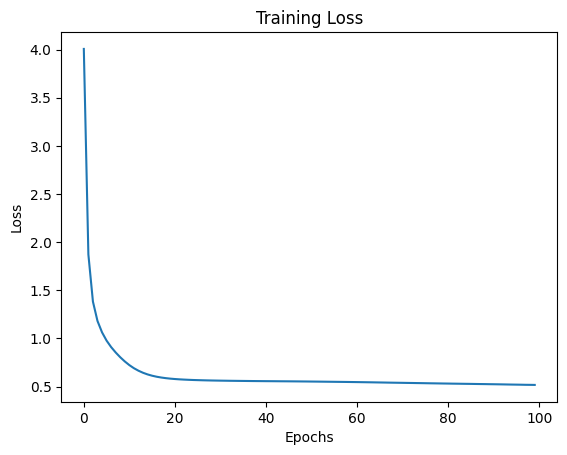

In [31]:
plot_train_loss(loss_points_word2vec)

## Troca de GRU por LSTM

Para realizar a troca da GRU pela LSTM, tive que realizar algumas mudanças no encoder e decoder, que foram basicamente trocar a camada da GRU pela a da LSTM e também realizar alguns ajustes no input e output da camada recorrente. Tendo isso em mente, nessa seção temos a implementação da LSTM com atenção Bahdanau. 

In [32]:
# Modifique o EncoderRNN para LSTM
class EncoderRNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.lstm(embedded)
        return output, (hidden, cell)

# Modifique o AttnDecoderRNN para LSTM
class AttnDecoderRNN_LSTM(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN_LSTM, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.lstm = nn.LSTM(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden, decoder_cell = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, (decoder_hidden, decoder_cell), attn_weights = self.forward_step(
                decoder_input, (decoder_hidden, decoder_cell), encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)
        return decoder_outputs, (decoder_hidden, decoder_cell), attentions

    def forward_step(self, input, hidden, encoder_outputs):
        decoder_hidden, decoder_cell = hidden
        embedded = self.dropout(self.embedding(input))
        query = decoder_hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_lstm = torch.cat((embedded, context), dim=2)
        output, (decoder_hidden, decoder_cell) = self.lstm(input_lstm, (decoder_hidden, decoder_cell))
        output = self.out(output)
        return output, (decoder_hidden, decoder_cell), attn_weights


In [33]:
encoder_LSTM = EncoderRNN_LSTM(
  input_size = len(input_dict.keys()),
  hidden_size = hidden_size
).to(device)

# decoder = DecoderRNN(
decoder_LSTM = AttnDecoderRNN_LSTM(
  hidden_size = hidden_size,
  output_size = len(output_dict.keys())
).to(device)


loss_points_LSTM = train(train_dataloader, encoder_LSTM, decoder_LSTM, 100, learning_rate=0.001)

Epoch:   10/ 100 - Loss: 0.6022
Epoch:   20/ 100 - Loss: 0.5629
Epoch:   30/ 100 - Loss: 0.5421
Epoch:   40/ 100 - Loss: 0.4640
Epoch:   50/ 100 - Loss: 0.3630
Epoch:   60/ 100 - Loss: 0.2219
Epoch:   70/ 100 - Loss: 0.0984
Epoch:   80/ 100 - Loss: 0.0406
Epoch:   90/ 100 - Loss: 0.0208
Epoch:  100/ 100 - Loss: 0.0129


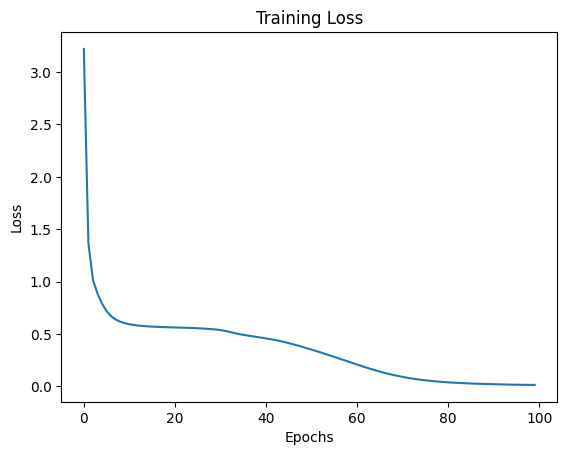

In [34]:
plot_train_loss(loss_points_LSTM)

## Adição Multihead Attention

Para realizar a criação do modelo com Multihead Attention, foi adaptado o código da atenção Bahdanau para ser compatível com o componente MultiheadAttention do pytorch. Assim com a ajuda da documentação do pytorch para o Multihead Attention (https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) foi criado o modelo GRU com MultiheadAttention

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads, batch_first=True)

    def forward(self, query, keys, values):
        # Calcula a atenção multihead e retorna o contexto e as atenções
        attn_output, attn_weights = self.attention(query, keys, values)
        return attn_output, attn_weights

class MultiHeadAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_heads=8, dropout_p=0.1):
        super(MultiHeadAttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = MultiHeadAttention(hidden_size, num_heads)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(decoder_input, decoder_hidden, encoder_outputs)
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))
        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)
        return output, hidden, attn_weights


In [36]:
encoder_mha = EncoderRNN(
  input_size = len(input_dict.keys()),
  hidden_size = hidden_size
).to(device)

# decoder = DecoderRNN(
decoder_mha = MultiHeadAttnDecoderRNN(
  hidden_size = hidden_size,
  output_size = len(output_dict.keys())
).to(device)


loss_points_mha = train(train_dataloader, encoder_mha, decoder_mha, 100, learning_rate=0.001)

Epoch:   10/ 100 - Loss: 0.5788
Epoch:   20/ 100 - Loss: 0.4836
Epoch:   30/ 100 - Loss: 0.3079
Epoch:   40/ 100 - Loss: 0.1055
Epoch:   50/ 100 - Loss: 0.0303
Epoch:   60/ 100 - Loss: 0.0135
Epoch:   70/ 100 - Loss: 0.0089
Epoch:   80/ 100 - Loss: 0.0058
Epoch:   90/ 100 - Loss: 0.0043
Epoch:  100/ 100 - Loss: 0.0035


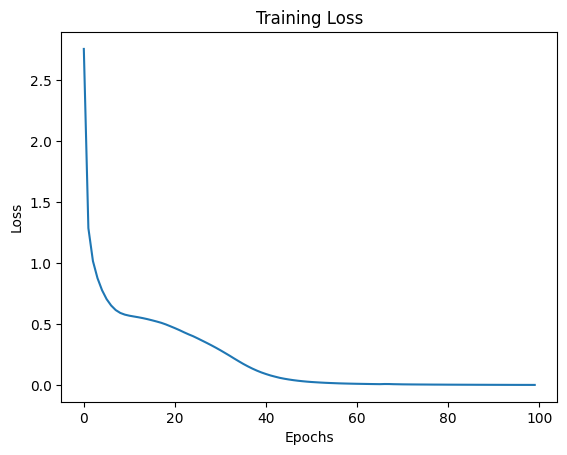

In [37]:
plot_train_loss(loss_points_mha)

# Análise

Abaixo contém o gráfico de Loss no treinamento ao longo das épocas de cada um dos modelos desenvolvidos.

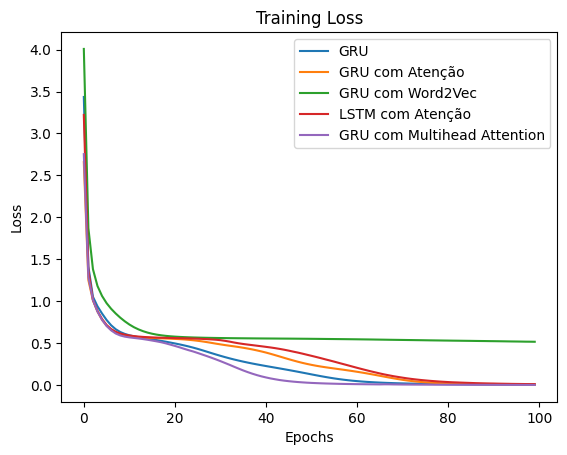

In [38]:
import matplotlib.pyplot as plt

def plot_train_loss_from_dict(loss_dict):
    for model_name, loss_points in loss_dict.items():
        plt.plot(loss_points, label=model_name)
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Exemplo de uso:
loss_dict = {
    'GRU': loss_points,
    'GRU com Atenção': loss_points_attention,
    'GRU com Word2Vec':loss_points_word2vec,
    'LSTM com Atenção':loss_points_LSTM,
    'GRU com Multihead Attention': loss_points_mha
}
plot_train_loss_from_dict(loss_dict)


O GRU com Multihead Attention obteve o menor loss final, destacando-se em desempenho, enquanto o GRU com Word2Vec apresentou o pior loss, mostrando-se menos eficaz. Modelos com atenção, como o LSTM com Atenção e o GRU com Atenção, também tiveram bons resultados, indicando que a atenção melhora a convergência, principalmente o modelo com o MultiHeadAttention.

# Com divisão de treino e teste

Nesta seção serão testados os mesmos modelos testados acima, porém será realizada uma divisão de treino e teste (80/20) e será calculada a métrica BLEU (Bilingual Evaluation Understudy) no conjunto de teste para avaliar o modelo. A métrica BLEU é calculada atráves de um método do pytorch (`sentence_bleu`) e abaixo há uma descrição do BLEU:

$$
\text{BLEU} = \text{BP} \times \exp\left(\sum_{n=1}^{N} w_n \log p_n\right)
$$

Onde:

- \( $p_n$ \) é a precisão dos n-gramas de tamanho \( n \).
- \( $w_n$ \) é o peso de cada n-grama (tipicamente igual para todos os \( n \), como \( w_n = \frac{1}{N} \)).
- \( $N$ \) é o maior tamanho de n-grama considerado (geralmente 4, então calculamos BLEU-4 usando uni, bi, tri e quatro-gramas).
- \($\text{BP}$\) é a **Penalidade de Brevidade** (brevity penalty), que penaliza frases curtas.

A precisão dos n-gramas \( $p_n$ \) é calculada como:

$$
p_n = \frac{\sum_{\text{candidatos}} \text{Contagem de } n\text{-gramas corretos}}{\sum_{\text{candidatos}} \text{Contagem total de } n\text{-gramas}}
$$

A penalidade de brevidade é dada por:

$$
\text{BP} = \begin{cases} 
      1 & \text{se } c > r \\
      e^{(1 - \frac{r}{c})} & \text{se } c \leq r 
   \end{cases}
$$

Onde:

- \( $c$ \) é o comprimento total das frases candidatas.
- \( $r$ \) é o comprimento total das frases de referência mais próximas em termos de comprimento.


**Aviso:** dado que com divisão de treino e teste é bastante similar a implementação anterior, terão poucos comentários nessa parte, pois não havia muito o que se comentar.

In [39]:
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu

# Divide o conjunto de pares em treino e teste (80% treino, 20% teste)
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2, random_state=42)

# Atualiza os dataloaders para treino e teste
train_dataloader = get_dataloader(batch_size, train_pairs, input_dict, output_dict)
test_dataloader = get_dataloader(batch_size, test_pairs, input_dict, output_dict)

## Sem Atenção

Epoch:   10/ 100 - Loss: 0.6822
Epoch:   20/ 100 - Loss: 0.5591
Epoch:   30/ 100 - Loss: 0.5015
Epoch:   40/ 100 - Loss: 0.3618
Epoch:   50/ 100 - Loss: 0.2580
Epoch:   60/ 100 - Loss: 0.2091
Epoch:   70/ 100 - Loss: 0.1285
Epoch:   80/ 100 - Loss: 0.0542
Epoch:   90/ 100 - Loss: 0.0244
Epoch:  100/ 100 - Loss: 0.0139
Grafico de loss ao longo do treinamento:


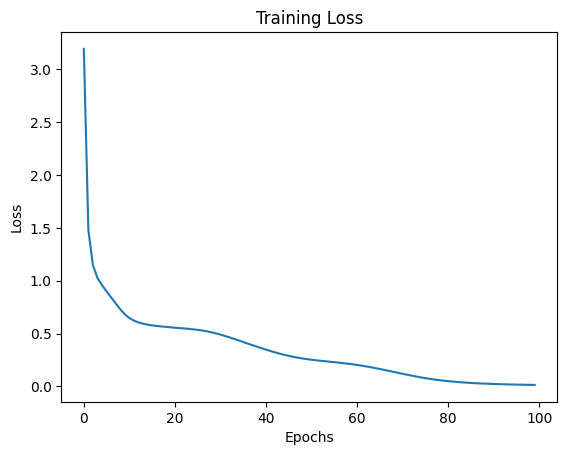

########################################################################


/home/semcovici/pesquisa/seq2seq/.conda/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/semcovici/pesquisa/seq2seq/.conda/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Média BLEU no conjunto de teste: 0.5367


In [ ]:
# Função para calcular BLEU
def calculate_bleu(reference, candidate):
    # reference and candidate are lists of words
    return sentence_bleu([reference], candidate)

# Avaliação do modelo com BLEU no conjunto de teste
def evaluate_test_set(encoder, decoder, test_pairs):
    bleu_scores = []
    for pair in test_pairs:
        input_sentence, ground_truth = pair
        output_words, _ = evaluate(encoder, decoder, input_sentence)
        
        # Tokeniza a frase ground truth e o output
        reference = [output_dict_reverse.get(output_dict[word], word) for word in re.split('([^a-zA-Z0-9])', ground_truth) if word.strip()]
        candidate = output_words
        
        # Calcula BLEU para a frase atual e armazena o resultado
        bleu_scores.append(calculate_bleu(reference, candidate))
    
    # Média do BLEU no conjunto de teste
    mean_bleu = np.mean(bleu_scores)
    print(f'Média BLEU no conjunto de teste: {mean_bleu:.4f}')
    return mean_bleu

# Treinamento do modelo
encoder = EncoderRNN(
    input_size = len(input_dict.keys()),
    hidden_size = hidden_size
).to(device)

decoder = DecoderRNN(
    hidden_size = hidden_size,
    output_size = len(output_dict.keys())
).to(device)

# Treina o modelo
loss_points = train(train_dataloader, encoder, decoder, 100, learning_rate=0.001)


print("Grafico de loss ao longo do treinamento:")

plot_train_loss(loss_points)

plt.show()

print("########################################################################")


# Avaliação no conjunto de teste
bleu_wo_att = evaluate_test_set(encoder, decoder, test_pairs)

## Adiciona Atenção BahdanauAttention

Epoch:   10/ 100 - Loss: 0.6396
Epoch:   20/ 100 - Loss: 0.5615
Epoch:   30/ 100 - Loss: 0.5348
Epoch:   40/ 100 - Loss: 0.4809
Epoch:   50/ 100 - Loss: 0.3836
Epoch:   60/ 100 - Loss: 0.2737
Epoch:   70/ 100 - Loss: 0.1542
Epoch:   80/ 100 - Loss: 0.0679
Epoch:   90/ 100 - Loss: 0.0312
Epoch:  100/ 100 - Loss: 0.0177
Grafico de loss ao longo do treinamento:


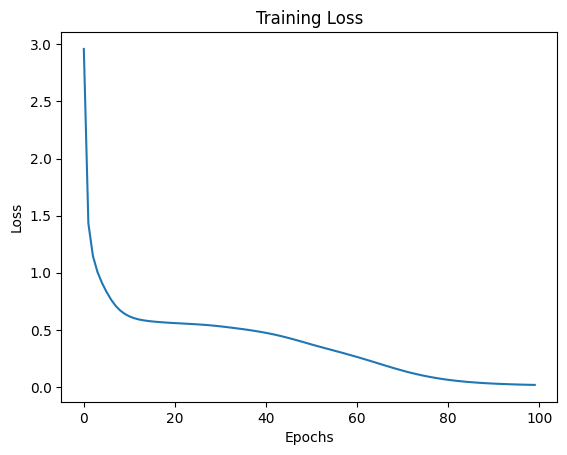

########################################################################


/home/semcovici/pesquisa/seq2seq/.conda/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Média BLEU no conjunto de teste: 0.5772


In [41]:
# Treinamento do modelo
encoder = EncoderRNN(
    input_size = len(input_dict.keys()),
    hidden_size = hidden_size
).to(device)

decoder = AttnDecoderRNN(
    hidden_size = hidden_size,
    output_size = len(output_dict.keys())
).to(device)

# Treina o modelo
loss_points_att = train(train_dataloader, encoder, decoder, 100, learning_rate=0.001)


print("Grafico de loss ao longo do treinamento:")

plot_train_loss(loss_points_att)

plt.show()

print("########################################################################")


# Avaliação no conjunto de teste
bleu_att = evaluate_test_set(encoder, decoder, test_pairs)

## Troca GRU por LSTM

Epoch:   10/ 100 - Loss: 0.6240
Epoch:   20/ 100 - Loss: 0.5687
Epoch:   30/ 100 - Loss: 0.5526
Epoch:   40/ 100 - Loss: 0.4958
Epoch:   50/ 100 - Loss: 0.4096
Epoch:   60/ 100 - Loss: 0.2819
Epoch:   70/ 100 - Loss: 0.1679
Epoch:   80/ 100 - Loss: 0.0881
Epoch:   90/ 100 - Loss: 0.0427
Epoch:  100/ 100 - Loss: 0.0234
Grafico de loss ao longo do treinamento:


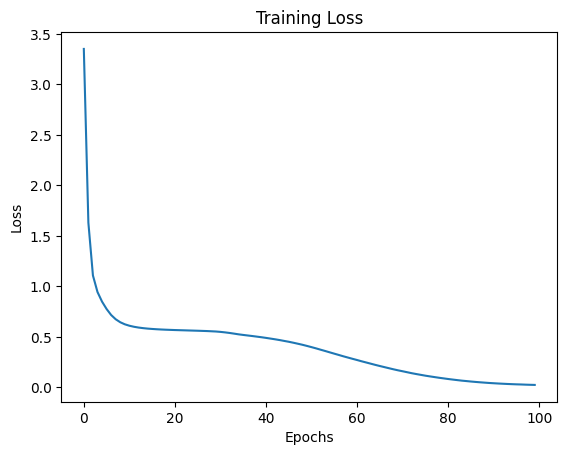

########################################################################
Média BLEU no conjunto de teste: 0.0013


In [42]:
# Atualiza o dataloader para treino
train_dataloader = get_dataloader(batch_size, train_pairs, input_dict, output_dict)

# Treinamento do modelo
encoder = EncoderRNN_LSTM(
    input_size = len(input_dict.keys()),
    hidden_size = hidden_size
).to(device)

decoder = AttnDecoderRNN_LSTM(
    hidden_size = hidden_size,
    output_size = len(output_dict.keys())
).to(device)

# Treina o modelo
loss_points_lstm = train(train_dataloader, encoder, decoder, 100, learning_rate=0.001)


print("Grafico de loss ao longo do treinamento:")

plot_train_loss(loss_points_lstm)

plt.show()

print("########################################################################")


# Avaliação no conjunto de teste
bleu_lstm = evaluate_test_set(encoder, decoder, test_pairs)

## Adição Multihead Attention

Epoch:   10/ 100 - Loss: 0.5984
Epoch:   20/ 100 - Loss: 0.5546
Epoch:   30/ 100 - Loss: 0.4646
Epoch:   40/ 100 - Loss: 0.3165
Epoch:   50/ 100 - Loss: 0.1935
Epoch:   60/ 100 - Loss: 0.0991
Epoch:   70/ 100 - Loss: 0.0453
Epoch:   80/ 100 - Loss: 0.0244
Epoch:   90/ 100 - Loss: 0.0158
Epoch:  100/ 100 - Loss: 0.0111
Grafico de loss ao longo do treinamento:


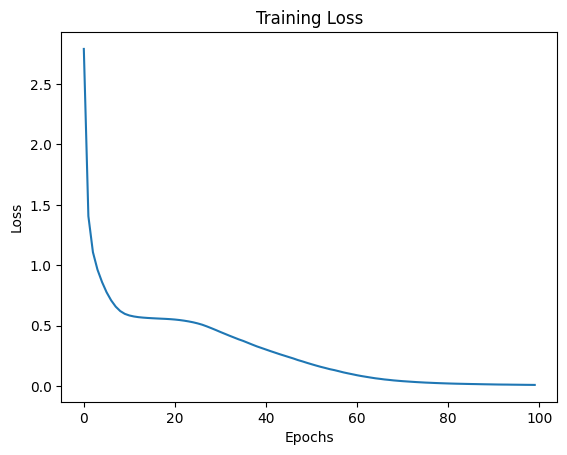

########################################################################
Média BLEU no conjunto de teste: 0.0036


In [43]:
# Atualiza o dataloader para treino
train_dataloader = get_dataloader(batch_size, train_pairs, input_dict, output_dict)

# Treinamento do modelo
encoder = EncoderRNN(
    input_size = len(input_dict.keys()),
    hidden_size = hidden_size
).to(device)

decoder = MultiHeadAttnDecoderRNN(
    hidden_size = hidden_size,
    output_size = len(output_dict.keys())
).to(device)

# Treina o modelo
loss_points_mha = train(train_dataloader, encoder, decoder, 100, learning_rate=0.001)


print("Grafico de loss ao longo do treinamento:")

plot_train_loss(loss_points_mha)

plt.show()

print("########################################################################")


# Avaliação no conjunto de teste
bleu_mha = evaluate_test_set(encoder, decoder, test_pairs)

## Substituição da representação simples de palavras por Word2Vec

Epoch:   10/ 100 - Loss: 0.8708
Epoch:   20/ 100 - Loss: 0.6094
Epoch:   30/ 100 - Loss: 0.5693
Epoch:   40/ 100 - Loss: 0.5604
Epoch:   50/ 100 - Loss: 0.5563
Epoch:   60/ 100 - Loss: 0.5542
Epoch:   70/ 100 - Loss: 0.5515
Epoch:   80/ 100 - Loss: 0.5434
Epoch:   90/ 100 - Loss: 0.5338
Epoch:  100/ 100 - Loss: 0.5224
Grafico de loss ao longo do treinamento:


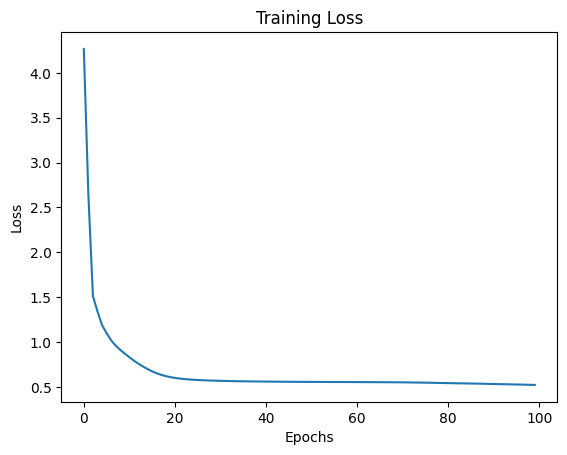

########################################################################
Média BLEU no conjunto de teste: 0.7347


In [44]:
# Função para calcular BLEU
def calculate_bleu(reference, candidate):
    # reference and candidate são listas de palavras
    return sentence_bleu([reference], candidate)

# Avaliação do modelo no conjunto de teste usando BLEU
def evaluate_test_set_w2v(encoder, decoder, test_dataloader, output_dict_reverse):
    encoder.eval()
    decoder.eval()
    bleu_scores = []

    with torch.no_grad():
        for input_tensor, target_tensor in test_dataloader:
            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden)

            _, topi = decoder_outputs.topk(1)
            decoded_ids = topi.squeeze()

            for i in range(decoded_ids.size(0)):
                reference = [output_dict_reverse[idx.item()] for idx in target_tensor[i] if idx.item() != EOS_token]
                candidate = [output_dict_reverse[idx.item()] for idx in decoded_ids[i] if idx.item() != EOS_token]
                bleu_scores.append(calculate_bleu(reference, candidate))

    mean_bleu = np.mean(bleu_scores)
    print(f'Média BLEU no conjunto de teste: {mean_bleu:.4f}')
    return mean_bleu

# Inicializa os modelos com embeddings CBOW
encoder_word2vec = EncoderRNN_word2vec(input_size=len(input_dict), hidden_size=hidden_size, embedding_matrix=input_embedding_matrix).to(device)
decoder_word2vec = AttnDecoderRNN_word2vec(hidden_size=hidden_size, output_size=len(output_dict), embedding_matrix=output_embedding_matrix).to(device)

# Treina o modelo no conjunto de treino
loss_points_word2vec = train(train_dataloader, encoder_word2vec, decoder_word2vec, 100, learning_rate=0.001)

print("Grafico de loss ao longo do treinamento:")

plot_train_loss(loss_points_word2vec)

plt.show()

print("########################################################################")

# Avalia o modelo no conjunto de teste
bleu_w2v = evaluate_test_set_w2v(encoder_word2vec, decoder_word2vec, test_dataloader, output_dict_reverse)


## Avaliação

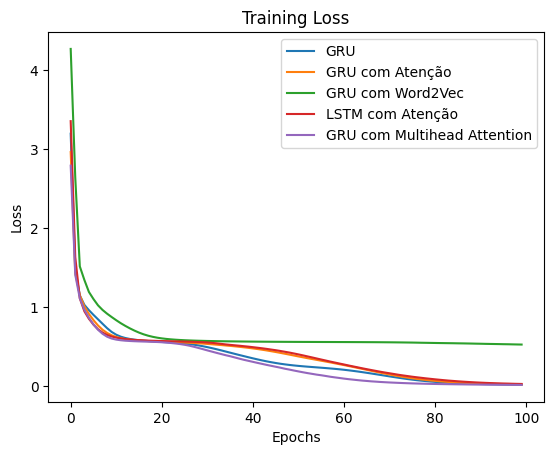

In [45]:
# Exemplo de uso:
loss_dict = {
    'GRU': loss_points,
    'GRU com Atenção': loss_points_att,
    'GRU com Word2Vec':loss_points_word2vec,
    'LSTM com Atenção':loss_points_lstm,
    'GRU com Multihead Attention': loss_points_mha
}
plot_train_loss_from_dict(loss_dict)


In [46]:
print('Resultado no conjunto de teste (BLEU):')
print(f'GRU: {bleu_wo_att}')
print(f'GRU com Atenção: {bleu_att}')
print(f'GRU com Word2Vec: {bleu_w2v}')
print(f'LSTM com Atenção: {bleu_lstm}')
print(f'GRU com Multihead Attention: {bleu_mha}')

Resultado no conjunto de teste (BLEU):
GRU: 0.5367247285393398
GRU com Atenção: 0.5771686472758845
GRU com Word2Vec: 0.7347225924082652
LSTM com Atenção: 0.001259819800142119
GRU com Multihead Attention: 0.0036109865597554144


Conclusão:

Dados os resultados, é possível ver que a GRU com word2vec foi a que saiu melhor no conjunto de teste, enquanto a LSTM com Atenção e a GRU com Multihead Attention foram as piores. A LSTM com atenção, dado o desempenho no conjunto de treino, é provável que tenha sofrido um processo de overffiting, sendo assim ruim no conjunto de teste e o mesmo se aplica a GRU com multihead attention.


Para essa tarefa, foi possível ver que a adição de uma camada de word2vec aumentou o desempenho, assim como a adição de atenção, seja ela qual for, mostrou bons resultados na convergência no treinamento. Porém, no conjunto de teste, a Multihead attention trouxe um dos piores resultados, por mais que tenha sido a que convergiu mais rapido no treinamento.